In [91]:
from pathlib import Path

import ResNet
from ResNetData import ResNetDataPreprocessor, ResNetDataset
from ResNetTrain import *

import torch

from torch.utils.data import DataLoader
from torchvision import transforms

from torchvision.models import resnet34, ResNet34_Weights

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

import matplotlib.pyplot as plt
import os

import random


Part a) Identify a few key layers in the pre-trained model that you want
to analyze. Consider selecting layers from different stages of the network (early,
middle, and late) to observe how the features evolve. As a starting point, you
might choose a layer close to the input, one in the middle of the network, and
one near the output.

In [92]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

DATASET_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/mandatory1_data/')
BASE_PATH = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/')

model = resnet34(weights=ResNet34_Weights.DEFAULT).to(device)
model.eval()

# Finding out which layers we have here
for name, module in model.named_children():
    print(name)

# choosing layers to look at
layer_names = ['layer1', 'layer3', 'layer4']


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


Part b) Use PyTorch’s forward hooks to capture the output of the selected
layers. A forward hook is a function that gets called every time a forward pass
is made through the layer, allowing you to capture and store the output (i.e.,
the feature map) of that layer. When you run a forward pass with an image, the
hook will automatically capture feature maps from layers where it is registered.

In [48]:
feature_maps = {}

def hook_function(module, input, output, layer_name):
    feature_maps[layer_name] = output.detach().cpu()

hooks = []
for name in layer_names:
    layer = dict(model.named_children())[name]  # finding the right layer in the model
    hook = layer.register_forward_hook(lambda module, input, output, name=name: hook_function(module, input, output, name))
    hooks.append(hook)

# looking at hooks
hooks

After registering your hooks, run a few forward passes with different images
from your dataset. This will trigger the hooks and store the feature maps for
each registered layer. Ensure that your hooks save the captured feature maps in
a way that you can easily access them later (e.g., storing them in a dictionary
with layer names as keys).

In [83]:
feature_maps = {}

# fetching data
preprocessor = ResNetDataPreprocessor(dataset_path=DATASET_PATH, base_path=BASE_PATH)

# defining our standard transform for a dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet needs 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# getting tha dataset from our existing code
test_dataset = ResNetDataset(preprocessor.annotations_file, BASE_PATH, split="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # using batch_size=1 for single images

# getting feature maps from some images
num_images = 5  # choosing the amount of images to analyse 
model.eval()

with torch.no_grad():
    for i, (image, label) in enumerate(test_loader):
        image = image.to(device)  # if we have GPU, move the image there
        model(image)  # a forward pass will activate the
        
        print(f"Feature maps stored for image {i+1}")
        
        if i+1 >= num_images:
            break

Success! Train, validation and test sets are disjoint.
Feature maps stored for image 1
Feature maps stored for image 2
Feature maps stored for image 3
Feature maps stored for image 4
Feature maps stored for image 5


Part c) Visualize the captured feature maps (from the previous task) to
see the patterns learned by each layer.

Looking at layer1 with 64 channels


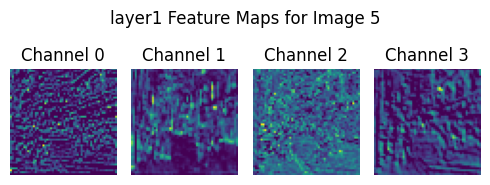

Looking at layer3 with 256 channels


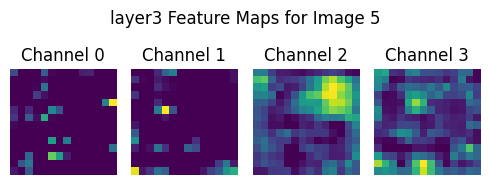

Looking at layer4 with 512 channels


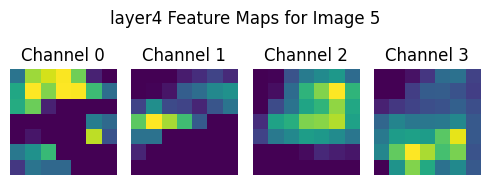

In [85]:
for i, (layer_name, feature_map) in enumerate(feature_maps.items()):
    feature_map = feature_map.squeeze(0)

    num_channels = feature_map.shape[0]
    print(f"Looking at {layer_name} with {num_channels} channels")

    num_to_show = min(4, num_channels)

    fig, axes = plt.subplots(1, 4, figsize=(5, 2))
    fig.suptitle(f"{layer_name} Feature Maps for Image 5")

    for channel in range(num_to_show):
        ax = axes[channel]
        ax.imshow(feature_map[channel].cpu().numpy(), cmap="viridis")
        ax.axis("off")
        ax.set_title(f"Channel {channel}")

    for i in range(num_to_show, 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()



In [86]:
# creating folder for the feature maps
save_dir = "feature_maps"
os.makedirs(save_dir, exist_ok=True)

# getting a batch of 10 images
batch_size = 10
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# getting one batch of 10 images
images, labels = next(iter(test_loader))
images = images.to(device)


In [87]:
model.eval()
with torch.no_grad():
    model(images)

In [89]:
def save_feature_maps(feature_map, layer_name, image_idx, save_dir, num_filters=6):

    feature_map = feature_map.squeeze(0)  # remove the batch dimension
    num_channels = feature_map.shape[0]   # number of feature maps

    # creating a folder for each image
    image_dir = os.path.join(save_dir, f"image_{image_idx}")
    os.makedirs(image_dir, exist_ok=True)

    for i in range(min(num_filters, num_channels)):
        plt.figure(figsize=(3, 3))
        plt.imshow(feature_map[i].numpy(), cmap="viridis")
        plt.axis("off")
        plt.title(f"{layer_name} - Filter {i}")

        # saving PNG
        save_path = os.path.join(image_dir, f"{layer_name}_filter_{i}.png")
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()  # closing up and freeing up memory

# generating feature maps
for img_idx in range(batch_size):
    for layer_name, feature_map in feature_maps.items():
        save_feature_maps(feature_map[img_idx].cpu(), layer_name, img_idx, save_dir)


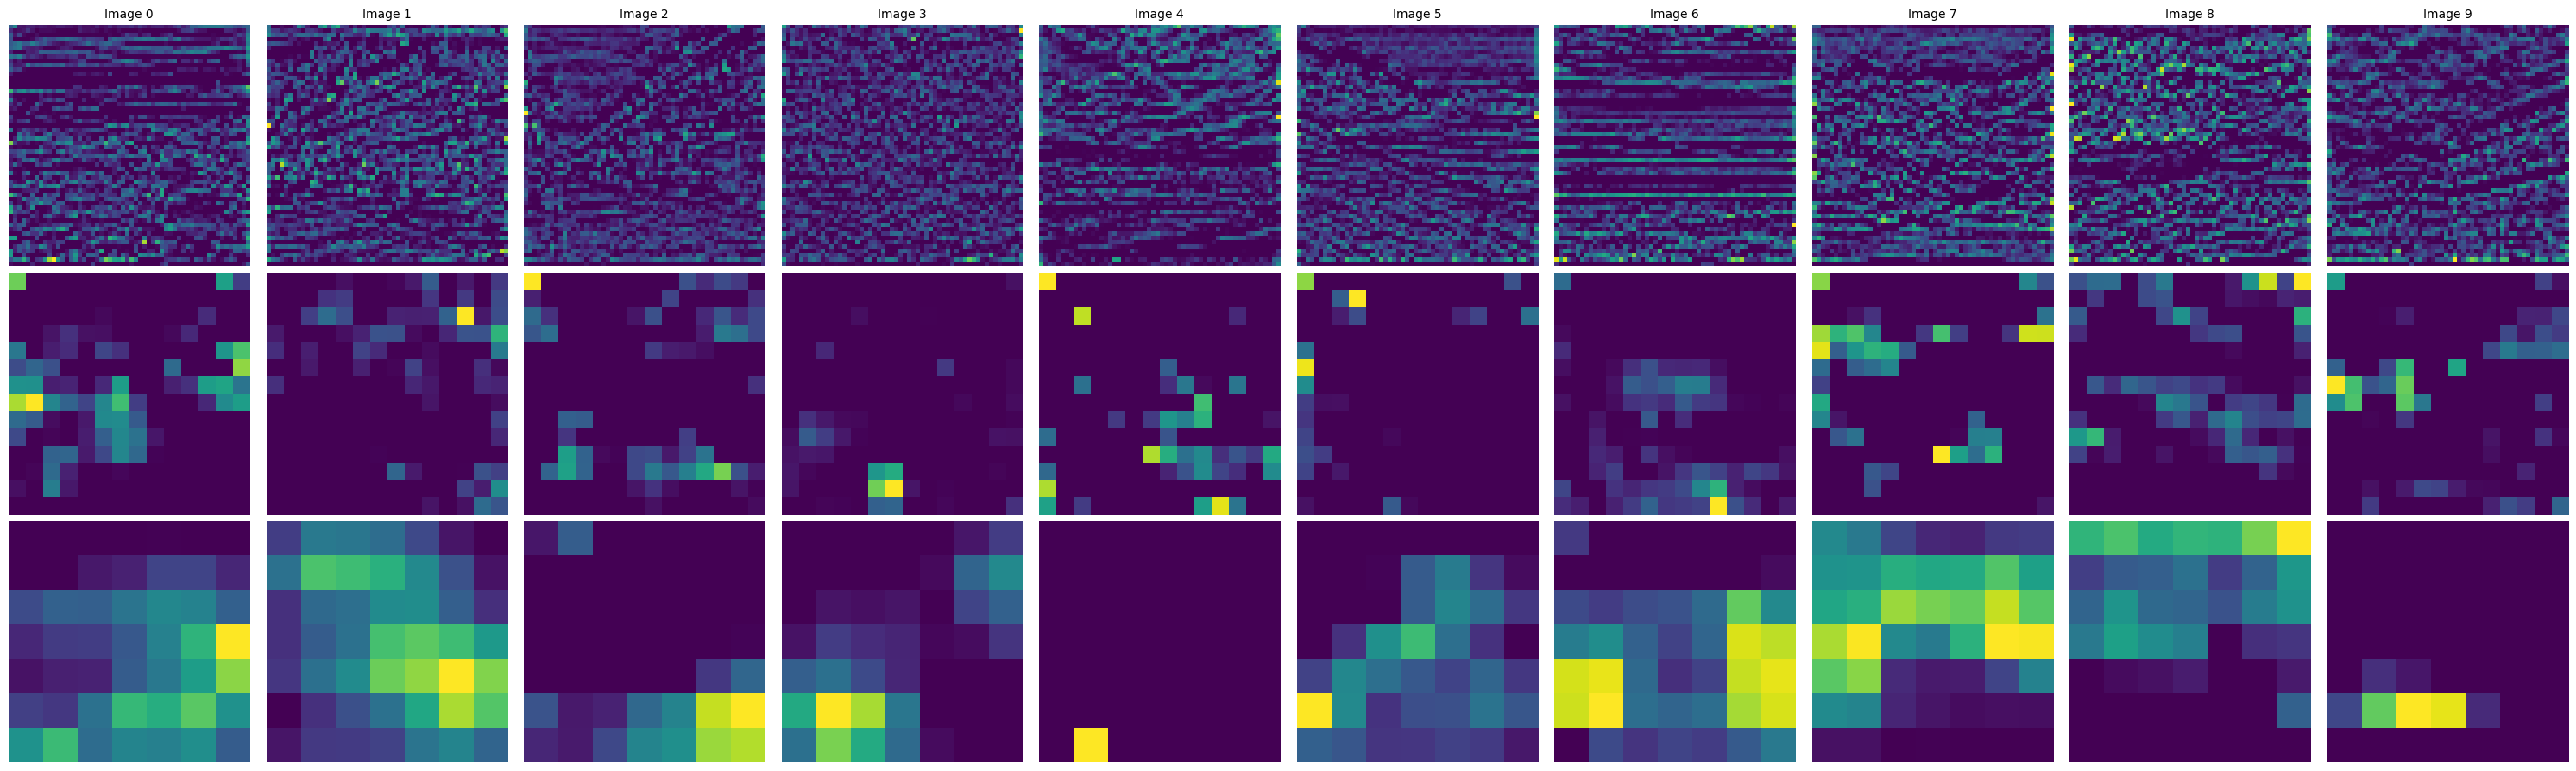

In [93]:
def plot_feature_maps_grid(feature_maps, image_idx_list, layer_names, num_filters=5):
    """
    Plot feature maps som et grid:
    - Rader = forskjellige lag (f.eks. conv1, layer2, layer4)
    - Kolonner = forskjellige bilder (f.eks. image_0, image_1, image_2)
    """
    
    num_images = len(image_idx_list)
    num_layers = len(layer_names)

    fig, axes = plt.subplots(num_layers, num_images, figsize=(num_images * 3, num_layers * 3))

    for row, layer_name in enumerate(layer_names):
        feature_map = feature_maps[layer_name]

        for col, img_idx in enumerate(image_idx_list):
            ax = axes[row, col] if num_layers > 1 else axes[col]  # handle one column
            fm = feature_map[img_idx]  # choose feature maps for this image

            # choose filter
            selected_filter = fm[0].cpu().numpy()  # first filter

            ax.imshow(selected_filter, cmap="viridis")
            ax.axis("off")

            # Legg til labels for første rad og første kolonne
            if row == 0:
                ax.set_title(f"Image {img_idx}", fontsize=10)
            if col == 0:
                ax.set_ylabel(layer_name, fontsize=12)

    plt.tight_layout()
    plt.show()

# Eksempelbruk
image_idx_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Plott fire bilder
plot_feature_maps_grid(feature_maps, image_idx_list, layer_names)


In [113]:
import random
from torch.utils.data import DataLoader

# Hent alle moduler og velg 5 tilfeldige ReLU-moduler
all_modules = list(model.named_modules())
relu_modules = [name for name, _ in all_modules if 'relu' in name.lower()]
selected_modules = sorted(random.sample(relu_modules, 5))

# Dictionary for å lagre feature maps
feature_maps = {}

# Hook-funksjon for å lagre feature maps
def hook_function(module, input, output, name):
    if name in selected_modules:
        if name not in feature_maps:
            feature_maps[name] = []
        feature_maps[name].append(output.detach().cpu())

# Registrer hooks for utvalgte moduler
hooks = []
for name, module in model.named_modules():
    if name in selected_modules:
        # Viktig: Bruk default-argument for å fikse "late binding"
        hook = module.register_forward_hook(
            lambda mod, inp, out, name=name: hook_function(mod, inp, out, name)
        )
        hooks.append(hook)

# Kjør modellen på 200 bilder
batch_size = 200
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(test_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    model(images)

# Rapporter resultater
for name in selected_modules:
    if name in feature_maps:
        non_positive_percentages = []
        for feature_map in feature_maps[name]:
            total_elements = feature_map.numel()
            non_positive_count = torch.sum(feature_map <= 0).item()
            percentage = (non_positive_count / total_elements) * 100
            non_positive_percentages.append(percentage)
        
        avg_percentage = sum(non_positive_percentages) / len(non_positive_percentages)
        print(f"Modul {name}: Gjennomsnittlig {avg_percentage:.2f}% ikke-positive verdier")
        
    # Slett feature maps for å spare lagringsplass
    del feature_maps[name]

# Fjern hooks når du er ferdig
for hook in hooks:
    hook.remove()


Modul layer1.0.relu: Gjennomsnittlig 34.16% ikke-positive verdier
Modul layer1.2.relu: Gjennomsnittlig 42.13% ikke-positive verdier
Modul layer3.1.relu: Gjennomsnittlig 57.45% ikke-positive verdier
Modul layer3.2.relu: Gjennomsnittlig 59.65% ikke-positive verdier
Modul layer3.5.relu: Gjennomsnittlig 68.41% ikke-positive verdier


In [125]:
# Hent alle moduler og velg 5 tilfeldige ReLU-moduler
all_modules = list(model.named_modules())
relu_modules = [name for name, _ in all_modules if 'relu' in name.lower()]
#selected_modules = sorted(random.sample(relu_modules, 5))
selected_modules = ['layer1.0.relu', 'layer2.0.relu', 'layer3.0.relu', 'layer4.0.relu', 'relu']

# Dictionary for å lagre feature maps
feature_maps = {}

# dict to save statistics
feature_stats = {name: {"avg": 0.0, "count": 0} for name in selected_modules}

# new hook function with iterative updating function (method 2 in the problem text)
def hook_function(module, input, output, name):

    if name in selected_modules:
        # calculating percent non-opositive values
        feature_map = output.detach().cpu()
        total_elements = feature_map.numel()
        non_positive_count = torch.sum(feature_map <= 0).item()
        percentage = (non_positive_count / total_elements) * 100
        
        # updating the average on the go
        current_avg = feature_stats[name]["avg"]
        current_count = feature_stats[name]["count"]
        
        # implementing the given formula: mt+1 = (mt * nt + ustep * nstep) / (nt + nstep)
        new_count = current_count + 1
        new_avg = (current_avg * current_count + percentage) / new_count
        
        # updating statistics
        feature_stats[name]["avg"] = new_avg
        feature_stats[name]["count"] = new_count


hooks = []
for name, module in model.named_modules():
    if name in selected_modules:
        hook = module.register_forward_hook(
            lambda mod, inp, out, name=name: hook_function(mod, inp, out, name)
        )
        hooks.append(hook)


# Kjør modellen på 200 bilder
batch_size = 200

preprocessor = ResNetDataPreprocessor(dataset_path=DATASET_PATH, base_path=BASE_PATH)
train_dataset = ResNetDataset(preprocessor.annotations_file, BASE_PATH, split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
images, _ = next(iter(test_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    model(images)


for name, item in feature_stats.items():
    avg = item["avg"]
    count = item["count"]
    print(f'Module: {name}, Average: {avg:.2f}%, Count: {count}')


Success! Train, validation and test sets are disjoint.
Module: layer1.0.relu, Average: 31.46%, Count: 13
Module: layer2.0.relu, Average: 48.32%, Count: 13
Module: layer3.0.relu, Average: 54.12%, Count: 11
Module: layer4.0.relu, Average: 67.81%, Count: 11
Module: relu, Average: 36.55%, Count: 6
